# Fooling neural networks, Part 2
### Hands-on code



Now it's time to poke around in some neural networks. This section will more or less rehash what I've written in [part 1](Attacking%20Neural%20Networks%20part%201.ipynb), but with concrete code examples that you can experiment with on your own machine. You'll need to [install TensorFlow](https://www.tensorflow.org/get_started/os_setup) as well as [Numpy](https://docs.scipy.org/doc/numpy/user/install.html) and [Matplotlib](http://matplotlib.org/users/installing.html#). 

The easiest way to get the dependencies lined up is by using [Anaconda Python](https://www.continuum.io/downloads). Unfortunately, the official Anaconda package library is a version behind on TensorFlow; it's got v0.11, and the rest of the world is on v0.12. The examples below assume you're using v0.11; I'll prepare a second copy with modifications for v0.12.

Let's import some libraries.

In [1]:
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's start with a simple multinomial logistic regression. For maximum clarity and support I'll use exactly the code supplied by [TensorFlow's introductory tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html); it's the first thing you'll write if you're new to machine learning. See the tutorial for an explanation of how this works.

In [2]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

print("Finished")

Finished


Now we've got weights and biases in `W` and `b`, respectively, that link the darkness of each pixel in an image to the probability that the image represents a particular digit. We can display the weights in `W` as `28 x 28` pixel images themselves. There's one image below for each digit between 0 and 9. Blue pixels represent positive weights (i.e., a pixel in a blue area corresponds to a higher probability that an image represents the corresponding digit), and red pixels represent negative weights.

0


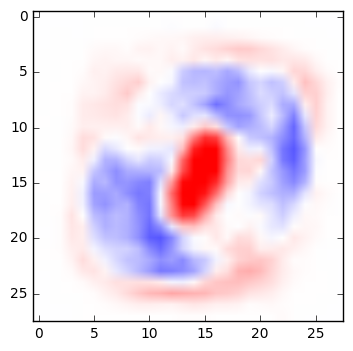

1


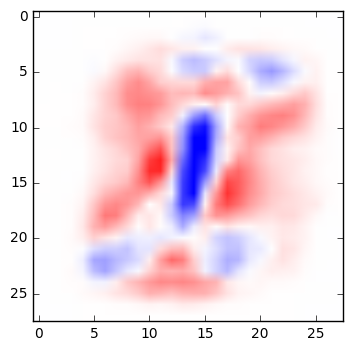

2


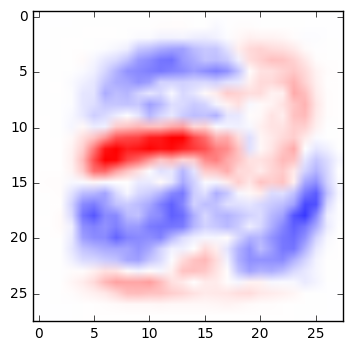

3


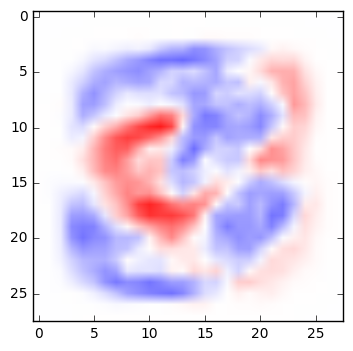

4


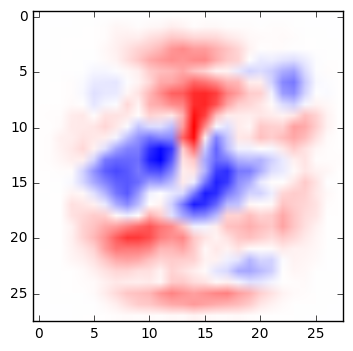

5


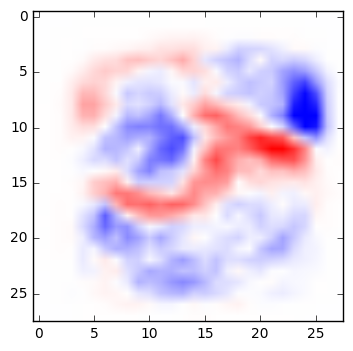

6


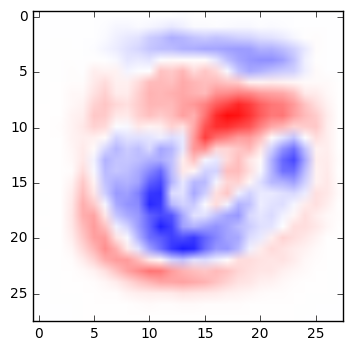

7


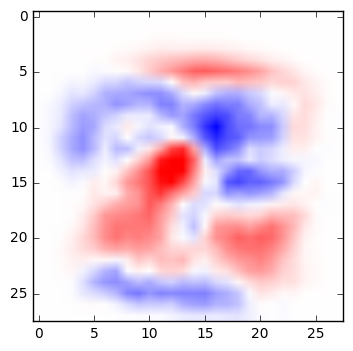

8


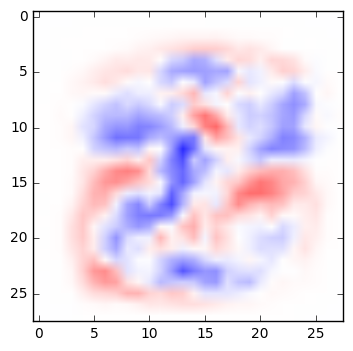

9


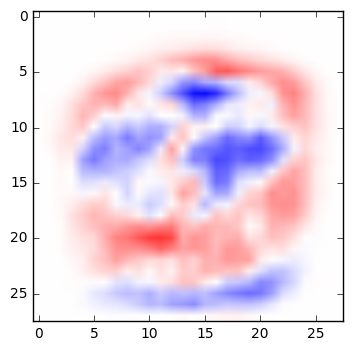

In [3]:
w = sess.run(W)

'''
w has 10 rows of 784 elements each, where w[n] contains the weights for digit n.
We need to reshape those elements into 28 x 28 pixel images each time we display one.
'''

for digit in range(10):
    map = w[0:, digit].reshape([28, 28])
    print(digit)
    plt.imshow(map, vmin=-0.5, vmax=0.5, cmap='bwr_r')
    plt.show()

Let's take a look at the images that the classifier gets wrong; we'll run through the first 200 images in the MNIST validation set and pick out the ones it misclassifies.

Model classification: 3


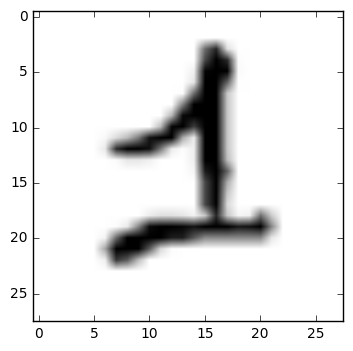

Model classification: 3


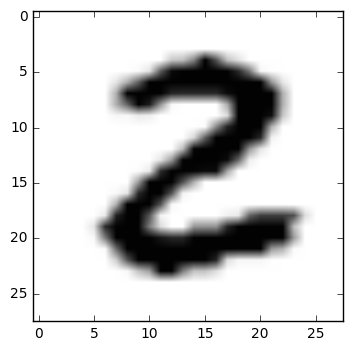

Model classification: 7


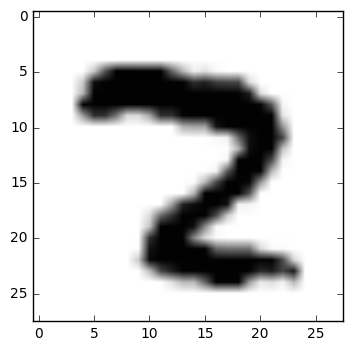

Model classification: 7


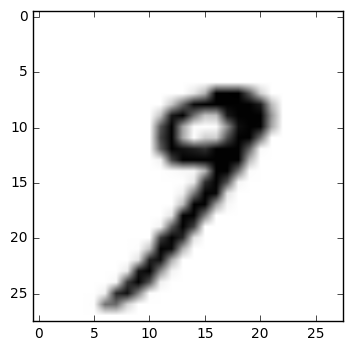

Model classification: 5


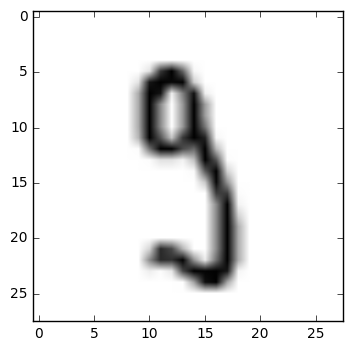

Model classification: 2


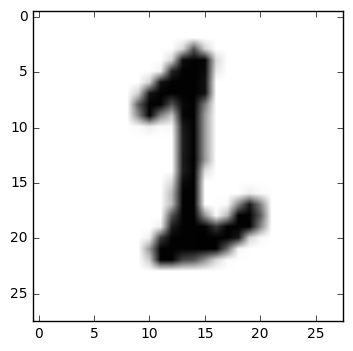

Model classification: 8


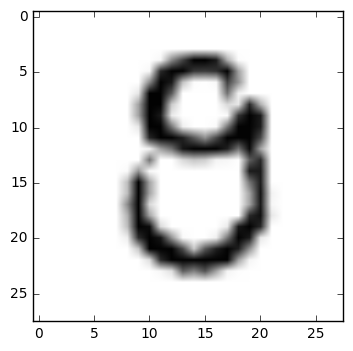

Model classification: 6


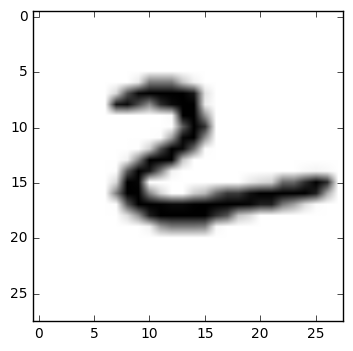

Model classification: 3


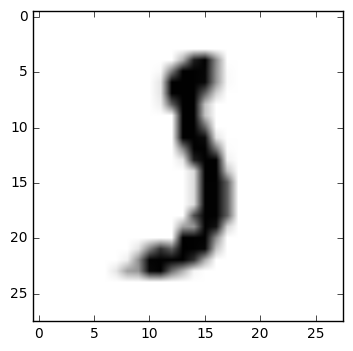

Model classification: 5


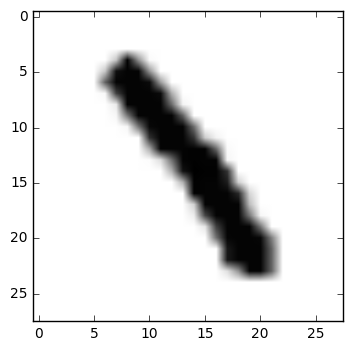

Model classification: 9


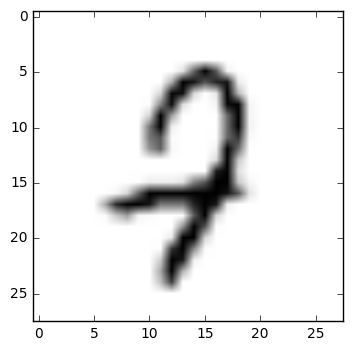

Model classification: 9


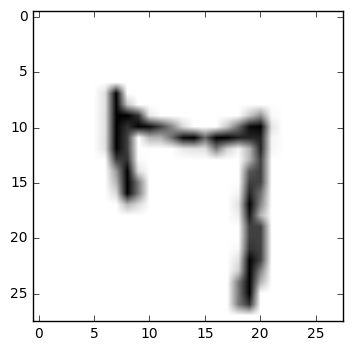

Model classification: 7


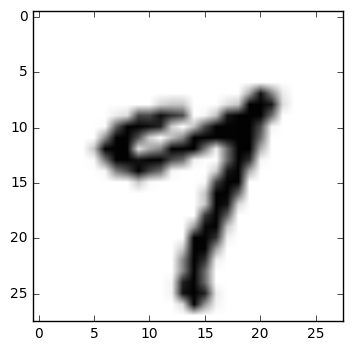

Model classification: 0


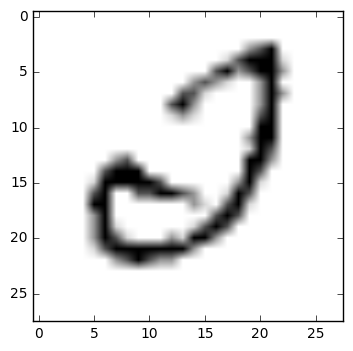

Model classification: 1


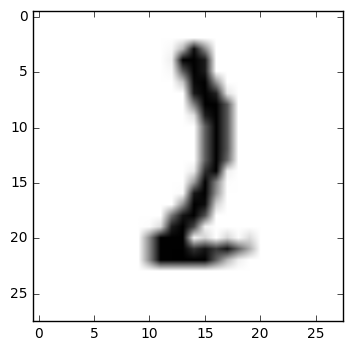

In [4]:
for i in range(200):
    img = mnist.validation.images[i].reshape([1, 784])
    label = mnist.validation.labels[i].reshape([1, 10])
    
    correct = tf.equal(tf.argmax(y,1), tf.argmax(y_,1)) # True when model's prediction is same as label
    result, model_prediction = sess.run([correct, tf.argmax(y, 1)], feed_dict={x:img, y_:label})

    if result[0] == False:
        print("Model classification:", model_prediction[0])
        plt.imshow(img.reshape([28, 28]), cmap='Greys')
        plt.show()

Now we'll move on to a convolutional neural network (CNN), and things won't be quite so clear. Here I set up and train the model specified in TensorFlow's ["Deep MNIST for Experts" documentation](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html).

**Run one of the following two cells.** The first one trains the CNN on your machine (it takes about 20 minutes on my laptop). The second one loads my pre-trained network from disk; if you've downloaded the entire directory containing this notebook, it should work. There's no need to run both!

I've made just a couple of modifications to the model as specified in the TensorFlow documentation: I've named every node so that we can more easily retrieve nodes from the saved version. This makes [TensorBoard visualization](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) a little easier to follow, too. I've also added a couple of lines that will save the resulting model on your disk, assuming there's a subdirectory in the current directory called `models`.

In [ ]:
# Run this if you want to train the network on your own machine
# (This takes a while)

tf.reset_default_graph()

def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)

x = tf.placeholder(tf.float32, shape=[None, 784], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y_')

W = tf.Variable(tf.zeros([784,10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b')

W_conv1 = weight_variable([5, 5, 1, 32], 'W_conv1')
b_conv1 = bias_variable([32], 'b_conv1')
x_image = tf.reshape(x, [-1,28,28,1], 'x_image')
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='h_conv1')
h_pool1 = max_pool_2x2(h_conv1, 'h_pool1')

W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
b_conv2 = bias_variable([64], 'b_conv2')
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
h_pool2 = max_pool_2x2(h_conv2, 'h_pool2')

W_fc1 = weight_variable([7 * 7 * 64, 1024], 'W_fc1')
b_fc1 = bias_variable([1024], 'b_fc1')
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name='h_pool2_flat')
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='h_fc1')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='h_fc1_drop')

W_fc2 = weight_variable([1024, 10], 'W_fc2')
b_fc2 = bias_variable([10], 'b_fc2')
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name="output")

sess = tf.InteractiveSession()

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]), name='cross_entropy')
train_step = tf.train.AdamOptimizer(1e-4, name='train_step').minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

sess.run(tf.initialize_all_variables())

# Putting this in a function to use later when we want to re-train

for i in range(10000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = sess.run(accuracy, feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g" % sess.run(accuracy, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

saver = tf.train.Saver()
save_path = saver.save(sess, "models/mnist_cnn.ckpt")
print("Model saved to %s" % save_path)

In [5]:
# Run this if you've downloaded my pre-trained model,
# or have already successfully run the cell above.

tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph('models/mnist_cnn.ckpt.meta')
new_saver.restore(sess, 'models/mnist_cnn.ckpt')

x = sess.graph.get_tensor_by_name("input:0")
y_conv = sess.graph.get_tensor_by_name("output:0")
keep_prob = sess.graph.get_tensor_by_name("keep_prob:0")

As you'll see below, this classifies handwritten digits pretty accurately, but it's also possible to generate images that look like noise but that the model recognizes as numerals with absolute certainy. Just like the humans whose reasoning it imitates, this model has developed heuristics that can be misled by cases that are very different from the cases it was trained on.

Let's generate an image that looks to this network like a 3. We're going to start with an image of random noise and adjust it incrementally until the network classifies it as a 3. differentiate each pixel with respect to its classification as a 3, and then either add to or subtract from the pixel value in order to increase the classification strength. Parts of this algorithm are [drawn from DeepDream](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb).

Recall that `y_conv` is the classification returned by the neural network for an image `x`, where `y_conv[:, digit]` is the probability that `x` is an image of a `digit`. We'll refer to `y_conv[:, digit]` as `returned_classification`. We're going to differentiate `returned_classification` with respect to the image `x` at every pixel to get a gradient for the image. If the gradient at a particular pixel is positive, that means we can make that pixel darker to make the image look more convincingly like `digit`. If the gradient is negative, we'll make the pixel lighter.

After several steps, the image of noise will have been adjusted slightly and unintuitively, but enough that the classifier will be almost certain it's a 3.

[[  1.89613383e-02   1.52659250e-05   1.08169485e-03   2.88158713e-04
    2.24073068e-04   3.22535852e-05   2.96067708e-04   2.26350341e-04
    9.78816032e-01   5.88632756e-05]]


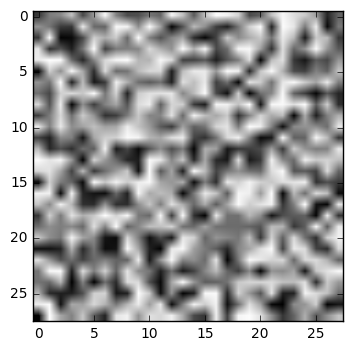

In [6]:
# Define the classification we're optimizing for
digit = 3

# This is the probability that an input image 
returned_classification = y_conv[:, digit]

# Here's our image of random noise going in
img_noise = np.random.uniform(size=(1, 784))

# Let's take a look at it and see how the network classifies it now.
plt.imshow(img_noise.reshape([28, 28]), cmap='Greys')
print(y_conv.eval({x: img_noise, keep_prob: 1}))

Indeed, this is an image of noise, and the classification returned by the network is accordingly confused. The probability that this image is a 3, according to this network, is the fourth element of the array above.

Now, let's nudge it toward looking like a 3.

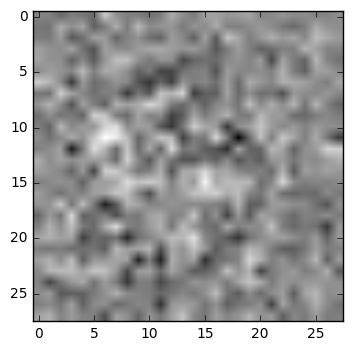

[[  3.16788197e-33   6.12324569e-29   1.19792605e-22   1.00000000e+00
    2.63372522e-37   1.17656077e-19   5.75016395e-32   2.10938276e-22
    6.55367841e-25   1.81396573e-24]]


In [7]:
gradient_op = tf.gradients(returned_classification, x)

for i in range(5):
    gradients = sess.run(gradient_op, {x: img_noise, keep_prob: 1})

    '''
    gradients now contains a 28 x 28 matrix. Each element is the derivative of
    the chosen classification with respect to a pixel in the image.
    '''

    gradients = gradients / (np.std(gradients) + 1e-8) # Normalize the gradients...
    img_noise = img_noise + gradients[0] # ...and add the normalized gradients to the image

plt.imshow(img_noise.reshape([28, 28]), cmap='Greys')
plt.show()

# Now, classify the adjusted img_noise
print(y_conv.eval({x: img_noise, keep_prob: 1}))

There you have it: the network is practically certain that this image, which still looks like noise, is a 3.

Now let's see if we can do the same thing to an image that's plainly another digit.

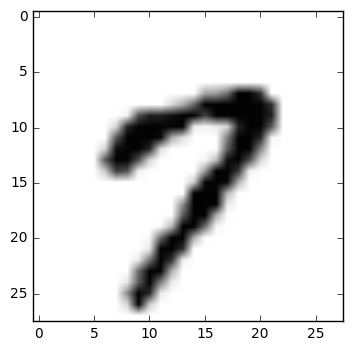

[[  1.53172985e-09   2.97516078e-09   1.76132726e-08   2.27402044e-08
    9.90620919e-09   3.37731665e-09   2.30080798e-12   9.99999285e-01
    3.49072393e-09   7.63104026e-07]]


In [8]:
numeral_image = mnist.validation.images[15].reshape([1, 784]).copy()

plt.imshow(numeral_image.reshape([28, 28]), cmap='Greys')
plt.show()
print(sess.run(y_conv, {x: numeral_image, keep_prob: 1}))

My network classifies this as a 7 with 99% certainty. Let's make it look like a 3. I'll repeat a few lines of code from above for clarity.

In the example above, the rate of adjustment was quite fast; if we repeat that, we'll reduce the image back to what looks like noise. I'll decrease the rate of adjustment here so that we can see the image start to get transformed, and will display the image after each adjustment.

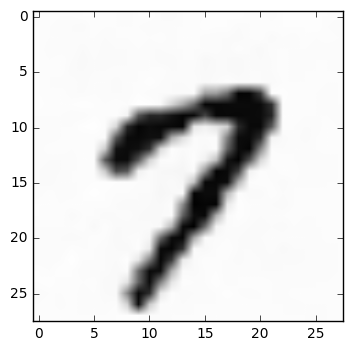

[[  8.47721893e-09   1.22893820e-08   1.16541372e-07   4.23430919e-07
    4.71434518e-08   1.96244851e-08   1.70194778e-11   9.99991179e-01
    2.85688717e-08   8.21004687e-06]]


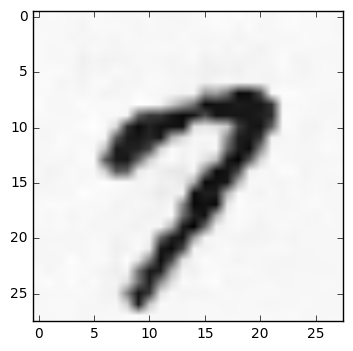

[[  2.17673175e-07   1.79544841e-07   3.55596990e-06   8.68456118e-05
    1.01897433e-06   4.31221082e-07   6.46664722e-10   9.99254405e-01
    1.41075964e-06   6.51944953e-04]]


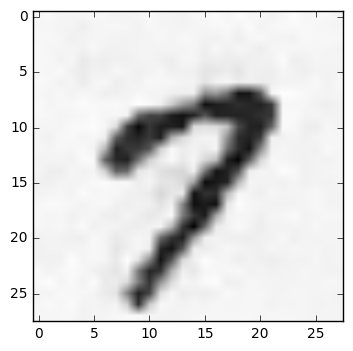

[[  4.97256860e-06   2.34844742e-06   1.11140667e-04   1.46012129e-02
    2.82146739e-05   7.44742329e-06   2.32395738e-08   9.48925614e-01
    6.80309313e-05   3.62510309e-02]]


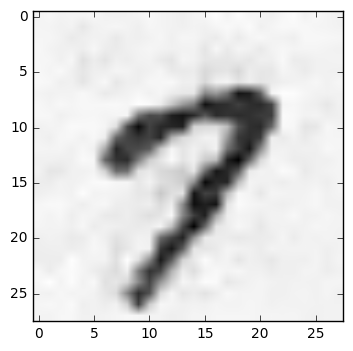

[[  2.82812780e-05   8.71360226e-06   1.01818249e-03   4.90104944e-01
    1.72469867e-04   3.00546635e-05   2.43595792e-07   2.47681335e-01
    1.12593209e-03   2.59829879e-01]]


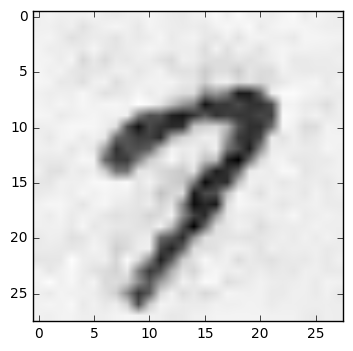

[[  6.31007970e-06   2.96139206e-06   6.33428455e-04   9.63673353e-01
    2.34492836e-05   4.66991105e-06   7.57272360e-08   2.78324317e-02
    3.96572781e-04   7.42673967e-03]]


In [9]:
digit = 3 # Target classification
returned_classification = y_conv[:, digit]
gradient_op = tf.gradients(returned_classification, x)

for i in range(5):
    gradients = sess.run(gradient_op, {x: numeral_image, keep_prob: 1})
    gradients = gradients / (np.std(gradients) + 1e-8)
    numeral_image = numeral_image + (gradients[0] * 0.02) # Adjusting by less than a full step each loop

    plt.imshow(numeral_image.reshape([28, 28]), cmap='Greys')
    plt.show()

    # Now, classify the adjusted img_noise
    print(y_conv.eval({x: numeral_image, keep_prob: 1}))

After just four iterations, the network is 96% certain that this image is a 3, despite the fact that it's plainly a 7 to a human observer.

Now go back up to the top of this notebook and re-train the network (you can train for fewer iterations if you don't want to wait for a while—just comment out the lines that save the model so that you can keep using the well-trained model in the next section). Now take a look at how the network classifies our fuzzed image: does it still think it's a 3?

In [10]:
print(sess.run(y_conv, {x: numeral_image, keep_prob: 1}))

[[  6.31007970e-06   2.96139206e-06   6.33428455e-04   9.63673353e-01
    2.34492836e-05   4.66991105e-06   7.57272360e-08   2.78324317e-02
    3.96572781e-04   7.42673967e-03]]


If you don't have the patience to sit through the retraining, the answer is: no, it doesn't misclassify this image as a 3 in the same way anymore. The image we generated above exploits the particular weights that the network developed when we first trained it, and those weights depend on particular bits of training data that we fed the network.

You could use this technique for steganography—sending hidden messages—by giving a copy of your network weights to someone else and generating optimized images for it. To an outside observer (or a network with a different set of weights), these images would look like random noise, but to your friend they'd be completely decodable.

## Interpreting a convolutional neural network

It doesn't get us very far to simply generate images that optimize for a particular output: the optimized images that we've generated look like noise to us despite the fact that, to the network, they look more like a 3 than an actual 3 does.

There are a few more promising methods for understanding how a more complex neural network reasons. First of all, we can look at how the convolutional layers respond when we feed in a familiar image.

The first convolutional layer looks for the same 32 features over and over again in `5 x 5` pixel patches. We don't know exactly what feature it will identify when we set up the network; that's one of the mysterious patterns that the network will discover for itself.

Let's use a nice image of a 3 and see how the first convolutional layer responds to it. We'll iterate over the 32 features that it's learned to identify, first displaying the weights for that feature, then displaying where on the image that feature gets activated.

(5, 5, 1, 32)
(1, 28, 28, 32)
Feature: 0


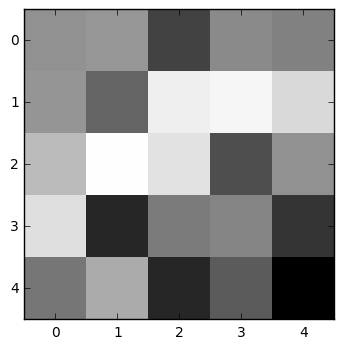

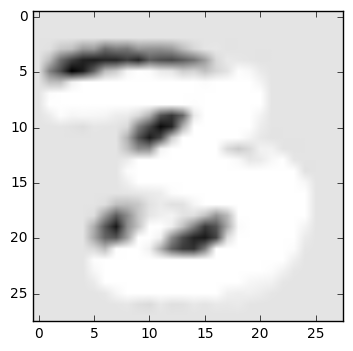

Feature: 1


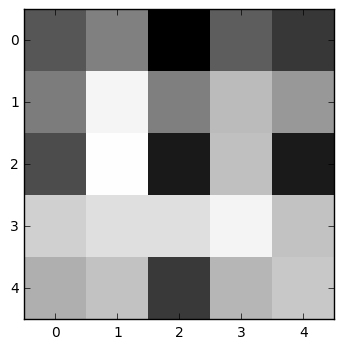

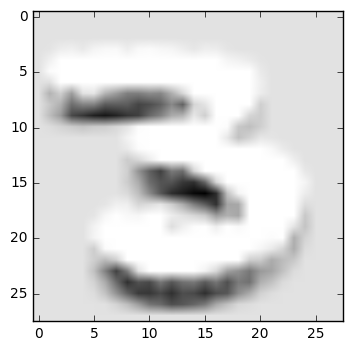

Feature: 2


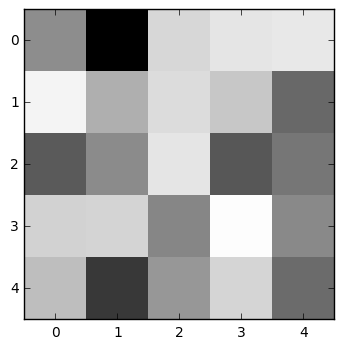

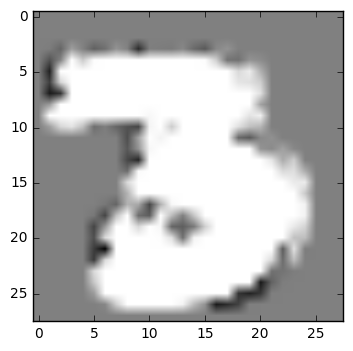

Feature: 3


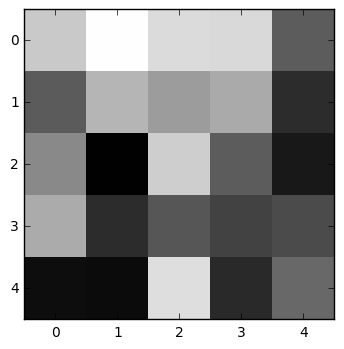

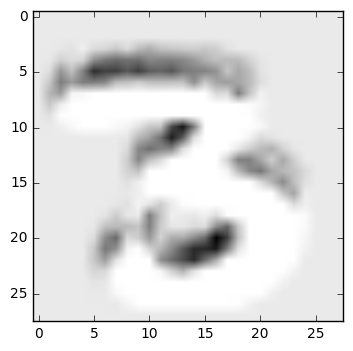

Feature: 4


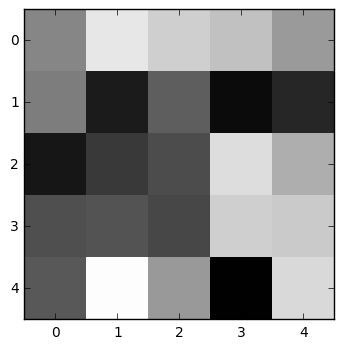

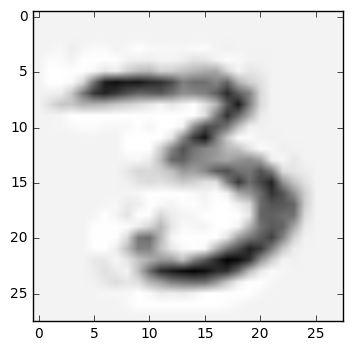

Feature: 5


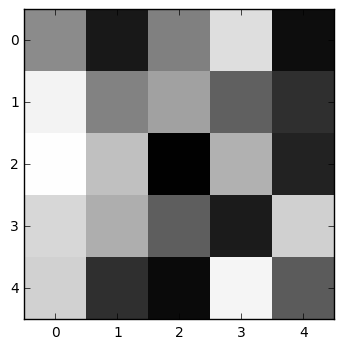

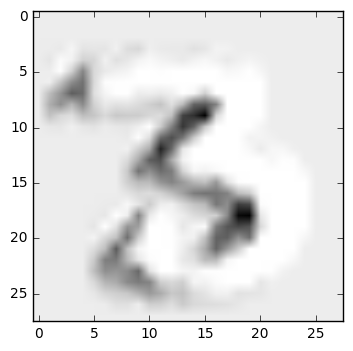

Feature: 6


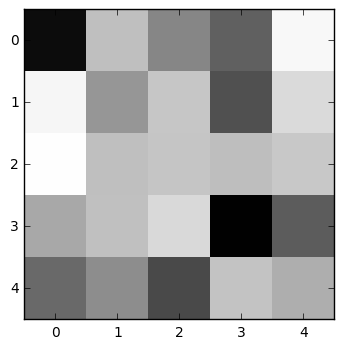

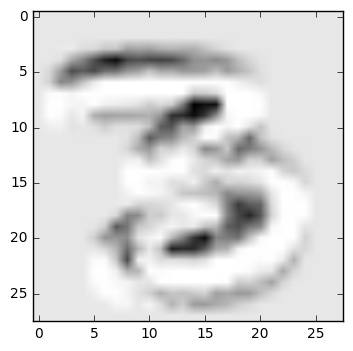

Feature: 7


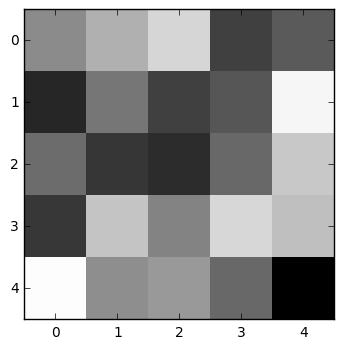

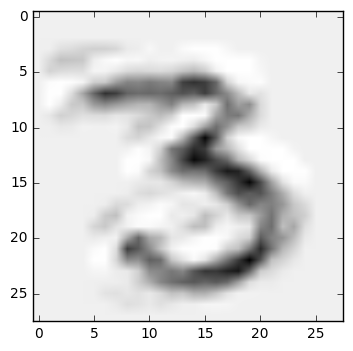

Feature: 8


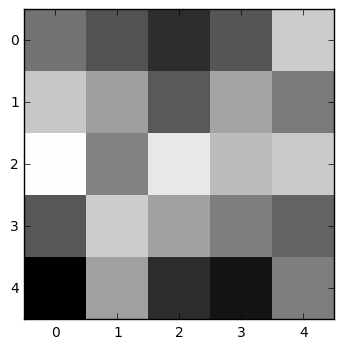

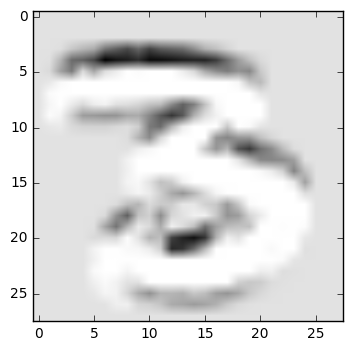

Feature: 9


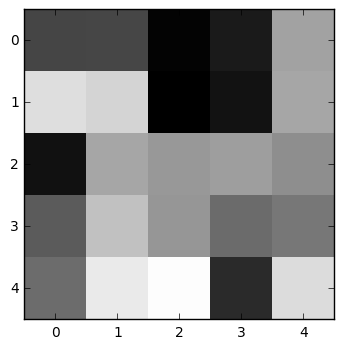

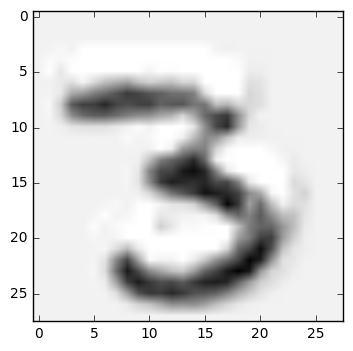

Feature: 10


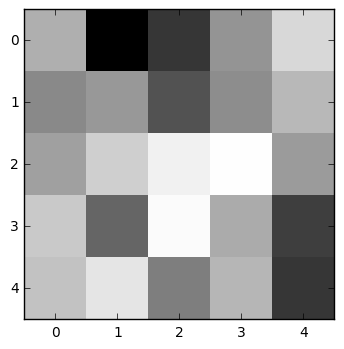

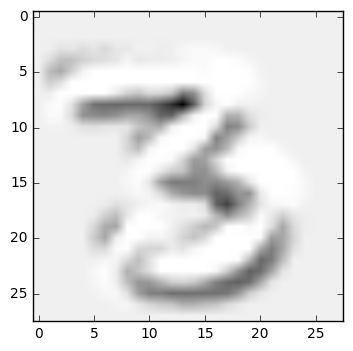

Feature: 11


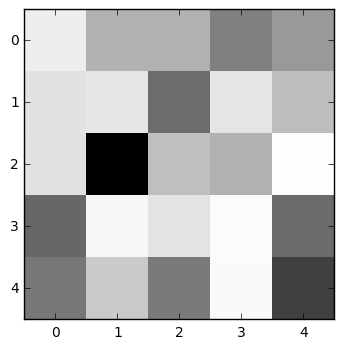

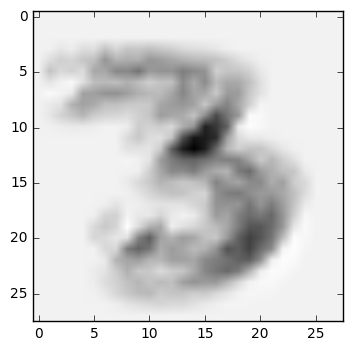

Feature: 12


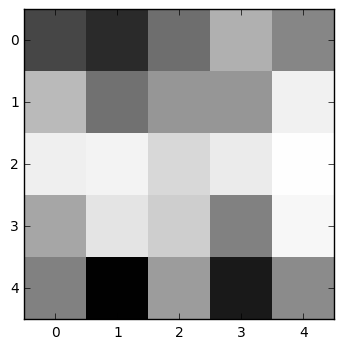

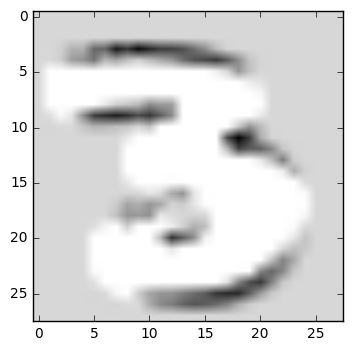

Feature: 13


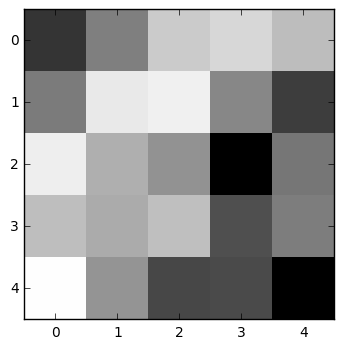

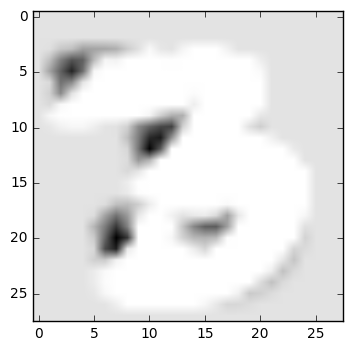

Feature: 14


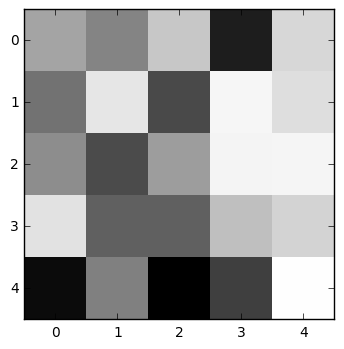

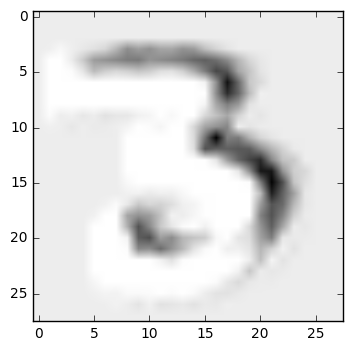

Feature: 15


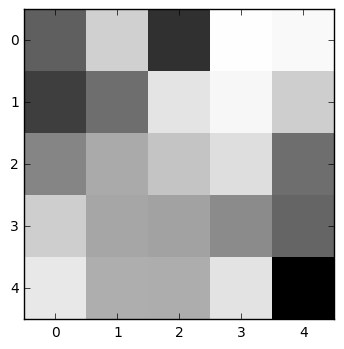

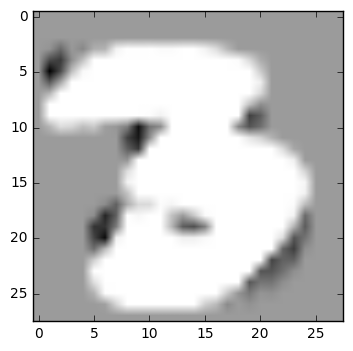

Feature: 16


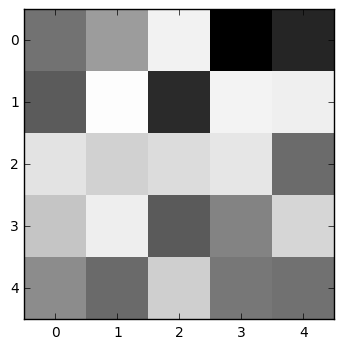

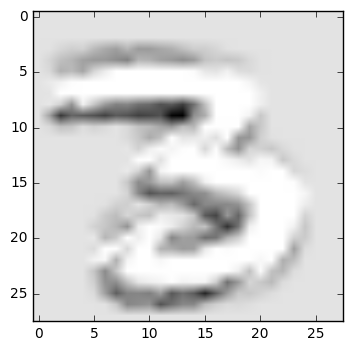

Feature: 17


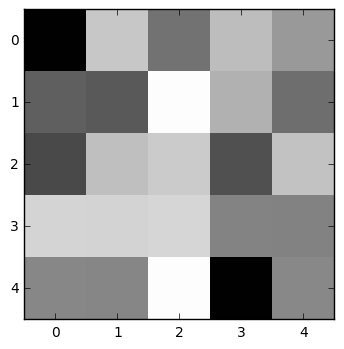

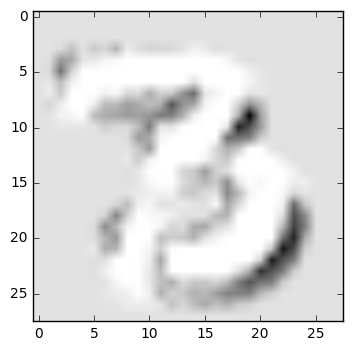

Feature: 18


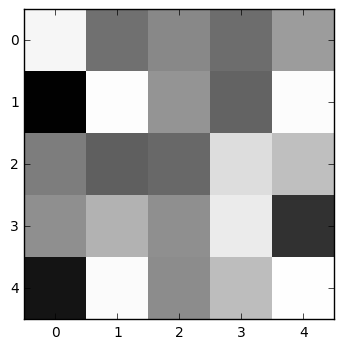

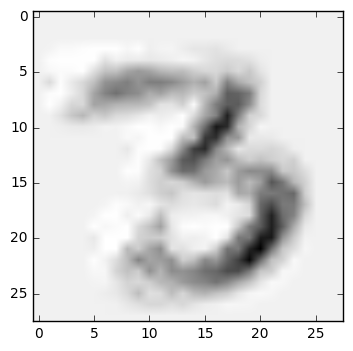

Feature: 19


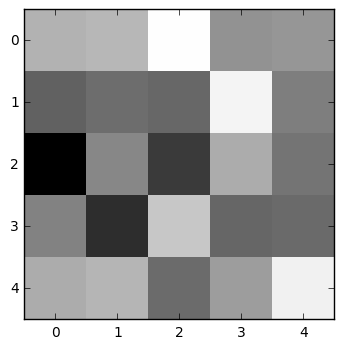

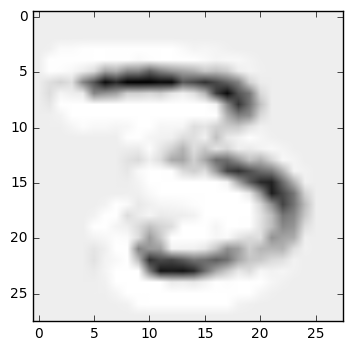

Feature: 20


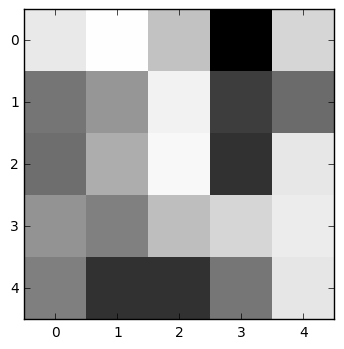

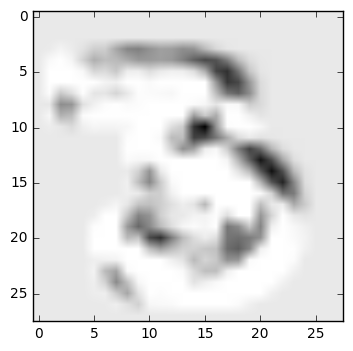

Feature: 21


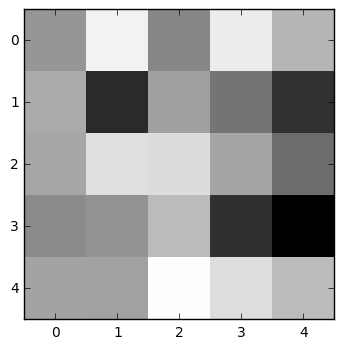

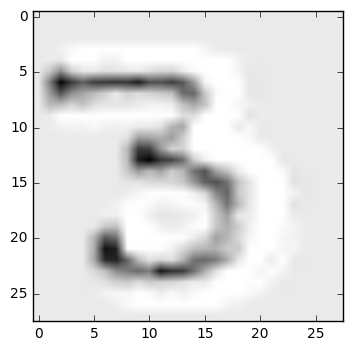

Feature: 22


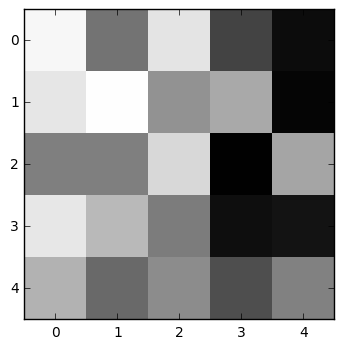

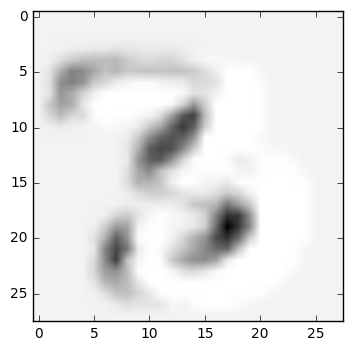

Feature: 23


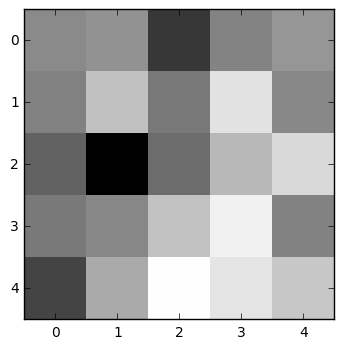

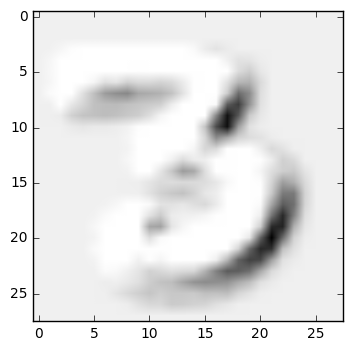

Feature: 24


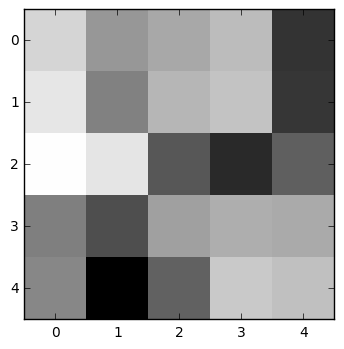

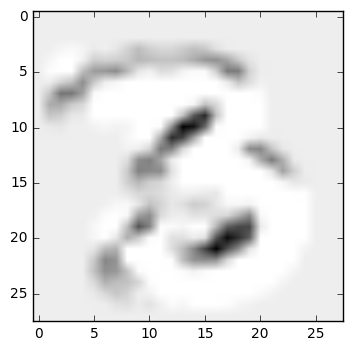

Feature: 25


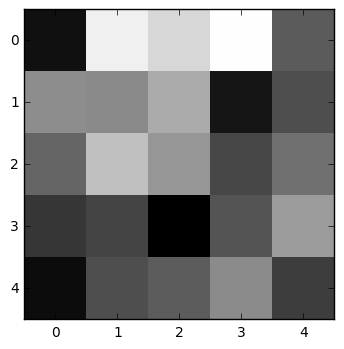

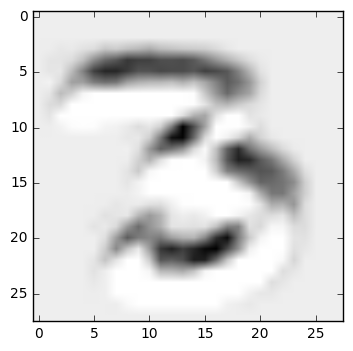

Feature: 26


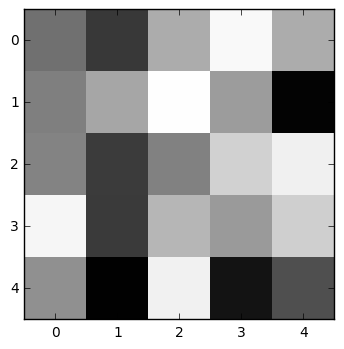

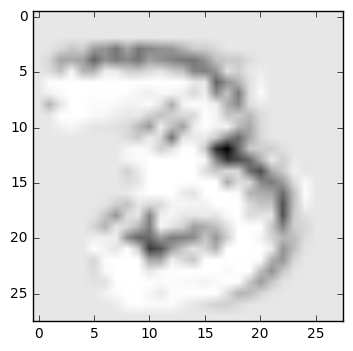

Feature: 27


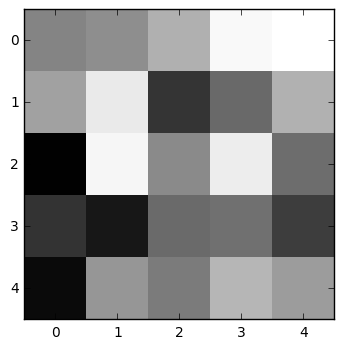

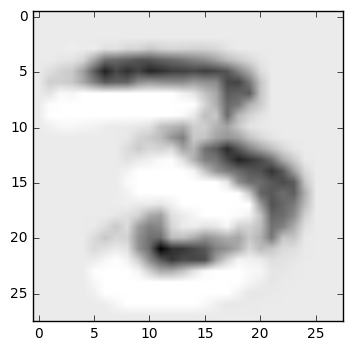

Feature: 28


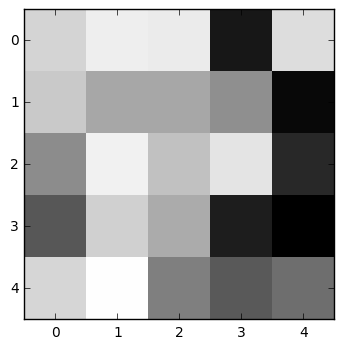

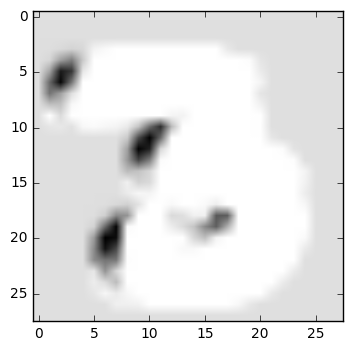

Feature: 29


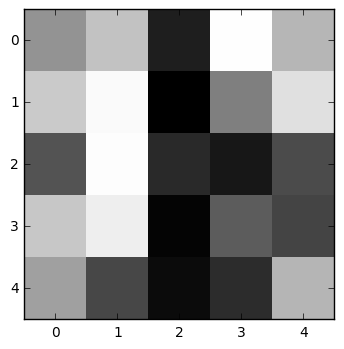

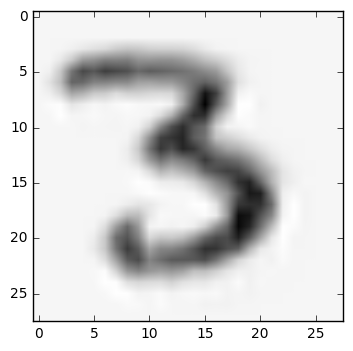

Feature: 30


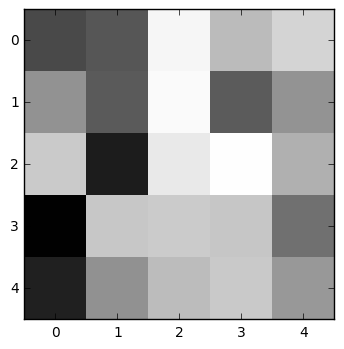

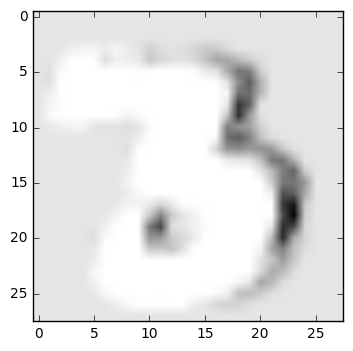

Feature: 31


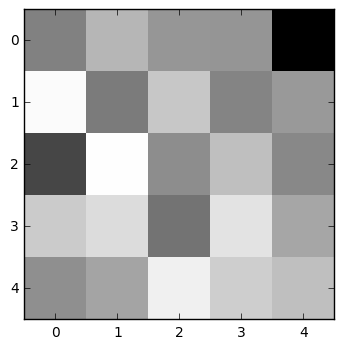

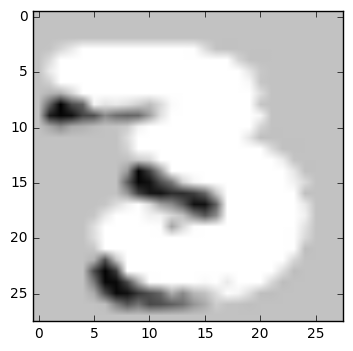

In [11]:
image = mnist.validation.images[12].reshape([1, 784]).copy()

w_conv1 = sess.graph.get_tensor_by_name("W_conv1:0").eval({x: image, keep_prob: 1})
print(w_conv1.shape)
h_conv1 = sess.graph.get_tensor_by_name("h_conv1:0").eval({x: image, keep_prob: 1})
print(h_conv1.shape)

for feature in range(32):
    print("Feature:", feature)
    plt.imshow(w_conv1[:, :, 0, feature], cmap='Greys', interpolation='none')
    plt.show()
    plt.imshow(h_conv1[0, :, :, feature].reshape([28, 28]), cmap='Greys')
    plt.show()

Another interesting way to understand the neural network's reasoning is to generate images that maximally activate different layers. Using a technique similar to the one we used above to generate images that tricked the network into misclassifying, we'll generate images that trigger the highest possible activation in the first convolutional layer.

Feature: 0


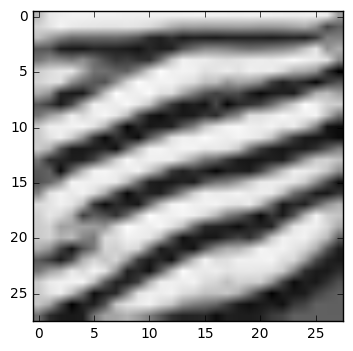

Feature: 1


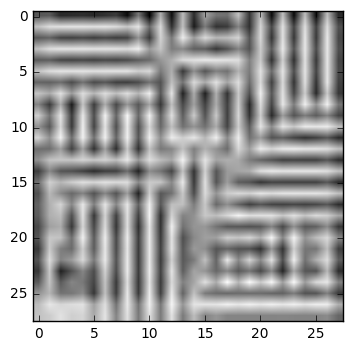

Feature: 2


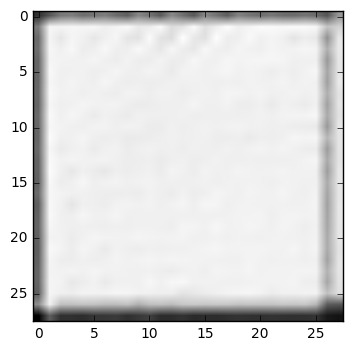

Feature: 3


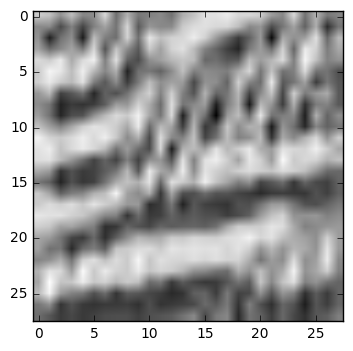

Feature: 4


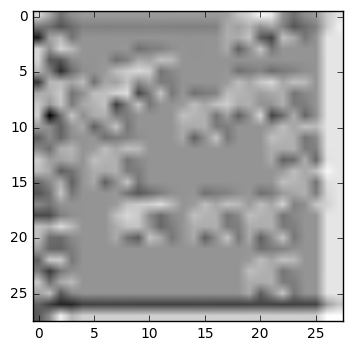

Feature: 5


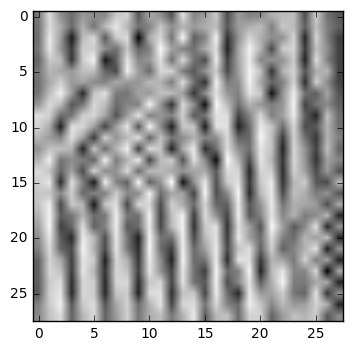

Feature: 6


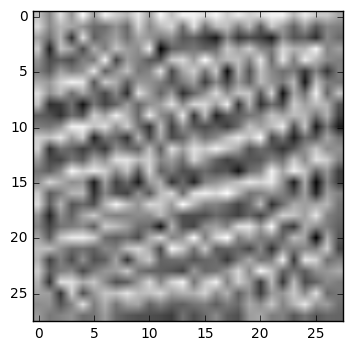

Feature: 7


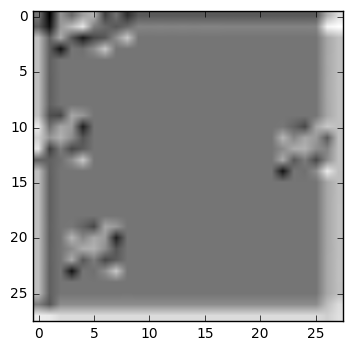

Feature: 8


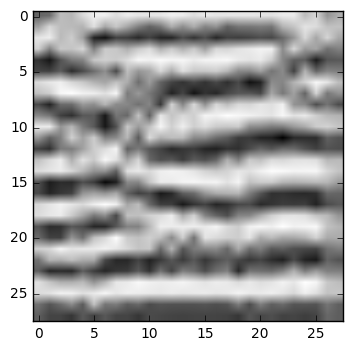

Feature: 9


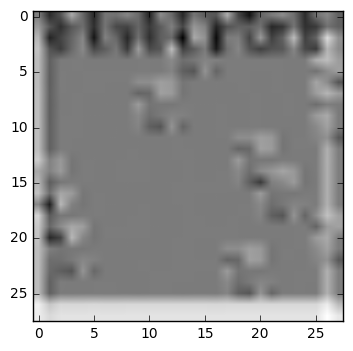

Feature: 10


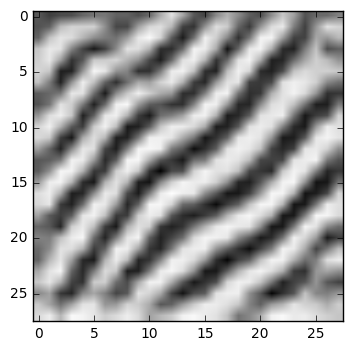

Feature: 11


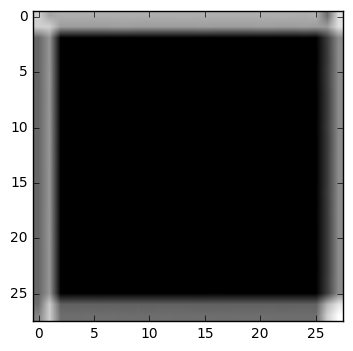

Feature: 12


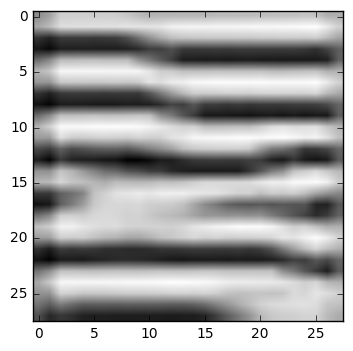

Feature: 13


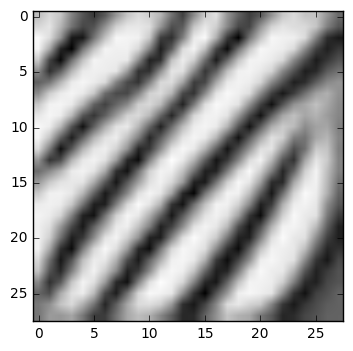

Feature: 14


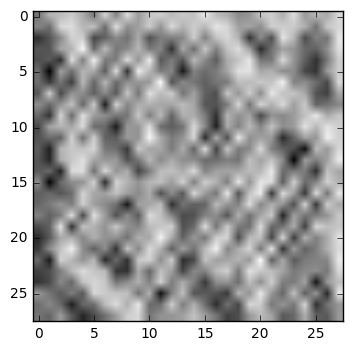

Feature: 15


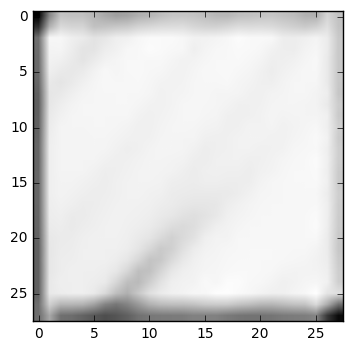

Feature: 16


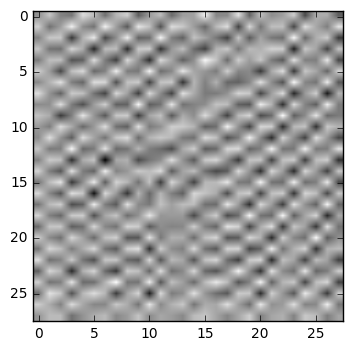

Feature: 17


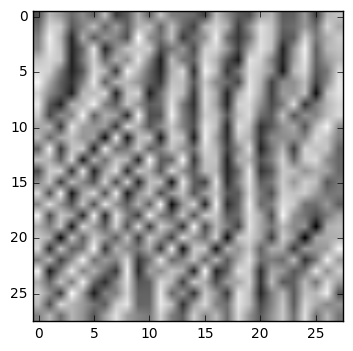

Feature: 18


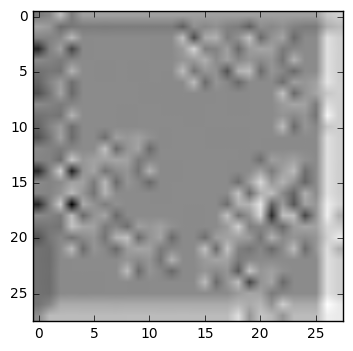

Feature: 19


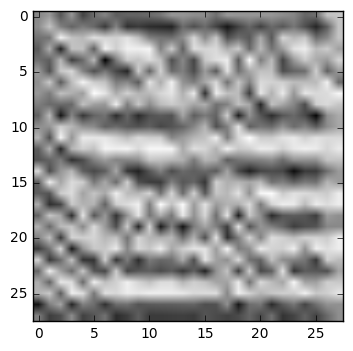

Feature: 20


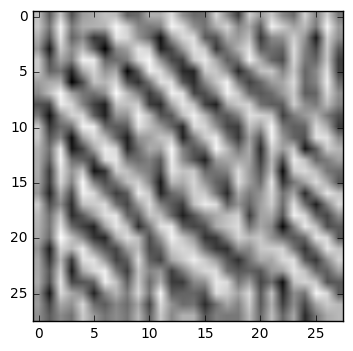

Feature: 21


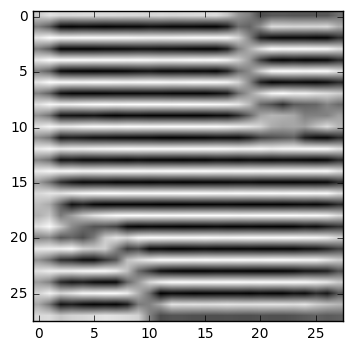

Feature: 22


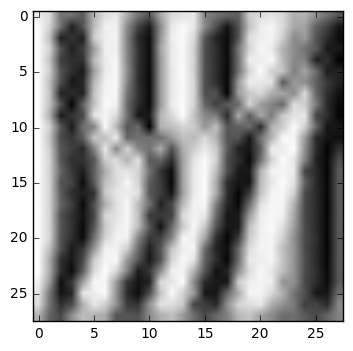

Feature: 23


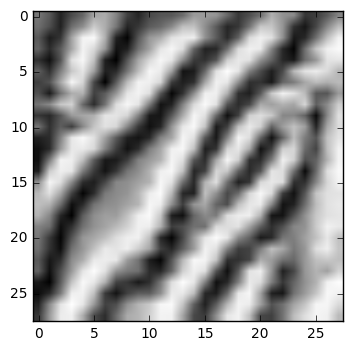

Feature: 24


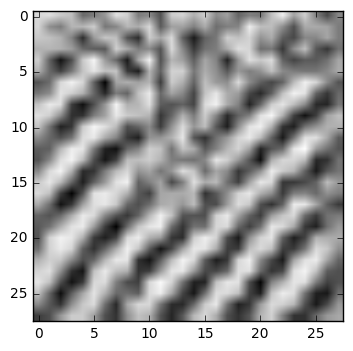

Feature: 25


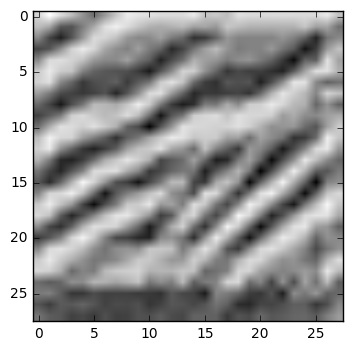

Feature: 26


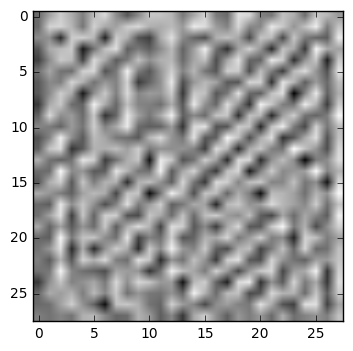

Feature: 27


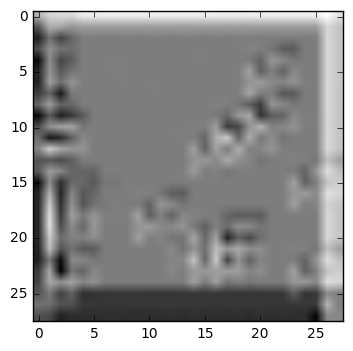

Feature: 28


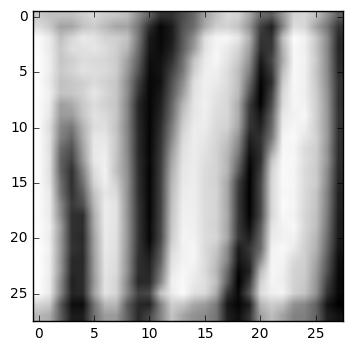

Feature: 29


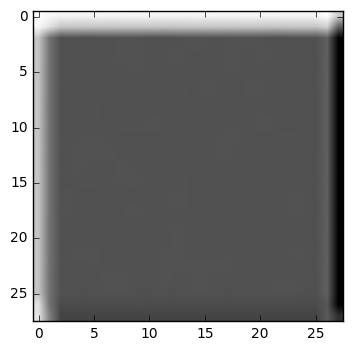

Feature: 30


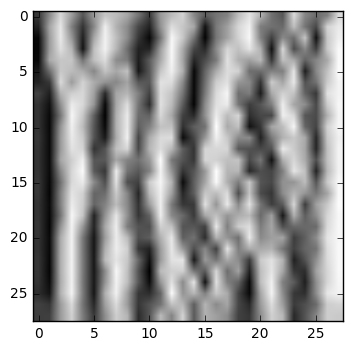

Feature: 31


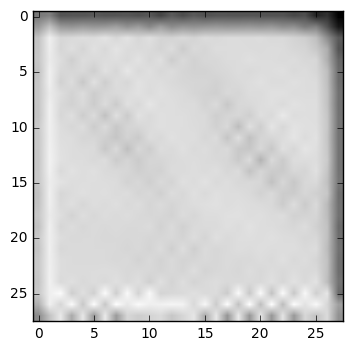

In [12]:
h_conv1 = sess.graph.get_tensor_by_name("h_conv1:0")

for feature in range(32):
    image = np.random.uniform(0, 1, [1, 784])
    layer = h_conv1
    grad = tf.gradients(tf.reduce_mean(layer[0, :, :, feature]), x)

    for i in range(50):
        g = sess.run(grad, {x: image})
        g /= np.std(g) + 1e-8
        image += g[0]


    print("Feature:", feature)
    plt.imshow(image.reshape([28, 28]), cmap='Greys')
    plt.show()

Let's line these images up to see how they work.

<table style="border:0">
    <tr style="border:0">
        <td style="border:0">
            Convolutional weights (filters)
        </td>
        <td style="border:0">
            <img src="images/convolution/w1.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/w2.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/w3.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/w4.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/w5.png"/>
        </td>
    </tr>
    <tr style="border:0">
        <td style="border:0">
            Convolutional activations on image of 3
        </td>
        <td style="border:0">
            <img src="images/convolution/h1.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/h2.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/h3.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/h4.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/h5.png"/>
        </td>
    </tr>
    <tr style="border:0">
        <td style="border:0">
            Image that maximally activates filter
        </td>
        <td style="border:0">
            <img src="images/convolution/a1.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/a2.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/a3.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/a4.png"/>
        </td>
        <td style="border:0">
            <img src="images/convolution/a5.png"/>
        </td>
    </tr>
</table>

Now we can see some interesting patterns emerge! The first filter, for instance, finds features where a dark area below contrasts with a light area above and to the left. As a result, it activates particularly well on the top-left edge of the 3. And the image that maximizes the activation of this filter, naturally, is a series of strongly contrasting, slightly wavy lines that trend slightly upward from left to right.

The second-to-last filter appears to activate when two light pixels are separated by a dark area, so it tends to find the upper and lower edges of the 3. And so on.

These are beautiful images, and represent a fascinating way of finding patterns in the world. You'd never think of handwritten digits as involving a pattern as rigid as the second one, for instance. As I've mentioned several times already, even this fairly simple neural network is capable of discovering many patterns in the real world that humans would never think to describe explicitly.

## [Return to part 1](Fooling%20Neural%20Networks%20part%201.ipynb)

## Further reading

A non-comprehensive list of some resources related to interpretability of neural networks:

—"[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)" by Alec Radford, Luke Metz, and Soumith Chintala (2015)

—"[Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)" by Matthew Zeiler and Rob Fergus (2013)

—"[Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)" by Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman (2013)

—"[Visualizing what ConvNets learn](http://cs231n.github.io/understanding-cnn/)" by Andrej Karpathy (class notes for Stanford's CS231n)

For more information on convolutions:

—Michael Nielsen's [chapter on convolutions](http://neuralnetworksanddeeplearning.com/chap6.html)